In [1]:
import sys

In [2]:
sys.path.append('..')

In [3]:
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import arviz as az
import pymc3 as pm
from causalgraphicalmodels import CausalGraphicalModel
from copy import deepcopy
import seaborn as sns
from helpers import create_standardizer_destandardizer

In [4]:
%matplotlib Inline

In [5]:
%config InlineBackend.figure_format = 'svg'

In [6]:
np.set_printoptions(formatter={float: lambda x: '{:,.3f}'.format(x)})
pd.set_option('display.float_format', lambda x: '{:,.3f}'.format(x))

# The Many Variables & The Spurious Waffles

## Codes 

### Code 5.1

In [7]:
d = pd.read_csv('../../data/WaffleDivorce.csv', sep=';')

In [8]:
std_D, dstd_D = create_standardizer_destandardizer(d['Divorce'])
std_M, dstd_M = create_standardizer_destandardizer(d['Marriage'])
std_A, dstd_A = create_standardizer_destandardizer(d['MedianAgeMarriage'])

In [9]:
d['D'] = std_D(d['Divorce'])
d['M'] = std_M(d['Marriage'])
d['A'] = std_A(d['MedianAgeMarriage'])

### Code 5.2

In [10]:
d['MedianAgeMarriage'].std()

1.2436303013880823

In [11]:
d.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860,D,M,A
0,Alabama,AL,4.780,25.300,20.200,1.270,12.700,0.790,128,1,435080,964201,0.450,1.654,0.023,-0.606
1,Alaska,AK,0.710,25.200,26.000,2.930,12.500,2.050,0,0,0,0,0.000,1.544,1.550,-0.687
2,Arizona,AZ,6.330,25.800,20.300,0.980,10.800,0.740,18,0,0,0,0.000,0.611,0.049,-0.204
3,Arkansas,AR,2.920,24.300,26.400,1.700,13.500,1.220,41,1,111115,435450,0.260,2.094,1.655,-1.410
4,California,CA,37.250,26.800,19.100,0.390,8.000,0.240,0,0,0,379994,0.000,-0.927,-0.267,0.600


### Code 5.3

In [12]:
with pm.Model() as m51:
    a = pm.Normal('a', 0, .2)
    bA = pm.Normal('bA', 0, .5)
    sigma = pm.Exponential('sigma', 1)
    mu = a + bA * d['A']
    D = pm.Normal('D', mu, sigma, observed=d['D'])
    prior = pm.sample_prior_predictive(50, model=m51)
    trace_51 = pm.sample()

/tmp/ipykernel_3442/1745926469.py:8: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_51 = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bA, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


### Code 5.4

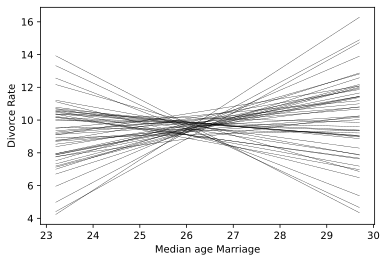

In [13]:
x = std_A(np.linspace(d['MedianAgeMarriage'].min(), d['MedianAgeMarriage'].max(), 50))

fig, ax = plt.subplots()
ax.set_xlabel('Median age Marriage')
ax.set_ylabel('Divorce Rate')

for i in range(len(prior['a'])):
    y = dstd_D(prior['a'][i] + prior['bA'][i] * x)
    ax.plot(dstd_A(x), y, color='black', linewidth=.3)

plt.show()

### Code 5.5

/home/giuliano/.pyenv/versions/miniconda3-4.7.12/envs/statistical-rethinking/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


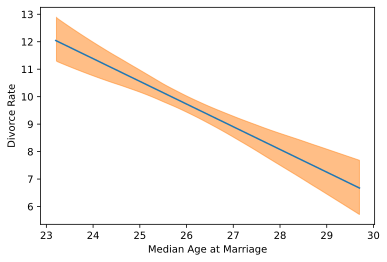

In [14]:
mu_pred = (trace_51['a'] + np.outer(x, trace_51['bA'])).T

fig, ax = plt.subplots()
ax.plot(dstd_A(x), dstd_D(mu_pred).mean(axis=0))
az.plot_hdi(dstd_A(x), dstd_D(mu_pred), hdi_prob=.89, ax=ax)
ax.set_xlabel('Median Age at Marriage')
ax.set_ylabel('Divorce Rate')
plt.show()

### Code 5.6

In [15]:
with pm.Model() as m52:
    a = pm.Normal('a', 0, .2)
    bM = pm.Normal('bM', 0, .5)
    sigma = pm.Exponential('sigma', 1)
    mu = a + bM * d['M']
    D = pm.Normal('D', mu, sigma, observed=d['D'])
    trace_52 = pm.sample()

/tmp/ipykernel_3442/1614454360.py:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_52 = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bM, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [16]:
x = std_M(np.linspace(d['Marriage'].min(), d['Marriage'].max(), 50))

/home/giuliano/.pyenv/versions/miniconda3-4.7.12/envs/statistical-rethinking/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


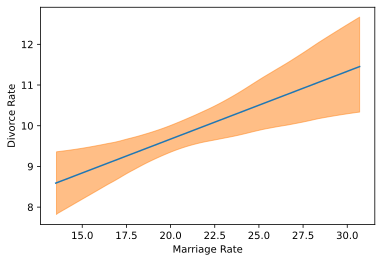

In [17]:
mu_pred = (trace_52['a'] + np.outer(x, trace_52['bM'])).T

fig, ax = plt.subplots()
ax.plot(dstd_M(x), dstd_D(mu_pred).mean(axis=0))
az.plot_hdi(dstd_M(x), dstd_D(mu_pred), hdi_prob=.89, ax=ax)
ax.set_xlabel('Marriage Rate')
ax.set_ylabel('Divorce Rate')
plt.show()

### Code 5.7

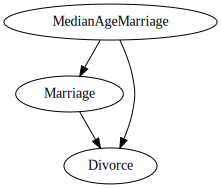

In [18]:
A = 'MedianAgeMarriage'
D = 'Divorce'
M = 'Marriage'

dag1 = CausalGraphicalModel(
    nodes=[A, M, D],
    edges=[
        (A, M),
        (A, D),
        (M, D),
    ]
)

dag1.draw()

In [19]:
d[['A', 'D', 'M']].corr()

,A,D,M
A,1.000,-0.597,-0.721
D,-0.597,1.000,0.374
M,-0.721,0.374,1.000


### Code 5.8-5.9

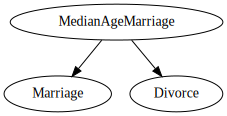

In [20]:
dag2 = CausalGraphicalModel(
    nodes=[A, M, D],
    edges=[
        (A, M),
        (A, D),
    ]
)
dag2.draw()

In [21]:
print('Dag1')
print(dag1.get_distribution())
print('Dag2')
print(dag2.get_distribution())

Dag1
P(MedianAgeMarriage)P(Marriage|MedianAgeMarriage)P(Divorce|MedianAgeMarriage,Marriage)
Dag2
P(MedianAgeMarriage)P(Marriage|MedianAgeMarriage)P(Divorce|MedianAgeMarriage)


In [22]:
print('Dag1')
print(dag1.get_all_independence_relationships())

Dag1
[]


In [23]:
print('Dag2')
print(dag2.get_all_independence_relationships())

Dag2
[('Marriage', 'Divorce', {'MedianAgeMarriage'})]


### Code 5.10

In [24]:
with pm.Model() as model_53:
    a = pm.Normal('a', 0, .2)
    bA = pm.Normal('bA', 0, .5)
    bM = pm.Normal('bM', 0, .5)
    mu = a + bA*d['A'] + bM*d['M']
    sigma = pm.Exponential('sigma', 1)
    D = pm.Normal('D', mu, sigma, observed=d['D'])
    
    prior_53 = pm.sample_prior_predictive(100)
    trace_53 = pm.sample(draws=1000, tune=10_000)

/tmp/ipykernel_3442/2984379883.py:10: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_53 = pm.sample(draws=1000, tune=10_000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bM, bA, a]


Sampling 4 chains for 10_000 tune and 1_000 draw iterations (40_000 + 4_000 draws total) took 26 seconds.


In [25]:
az.summary(trace_53, hdi_prob=.89, kind='stats')

/home/giuliano/.pyenv/versions/miniconda3-4.7.12/envs/statistical-rethinking/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%
a,0.001,0.101,-0.154,0.167
bA,-0.599,0.158,-0.835,-0.346
bM,-0.055,0.159,-0.309,0.199
sigma,0.825,0.086,0.693,0.964


### Code 5.11

/home/giuliano/.pyenv/versions/miniconda3-4.7.12/envs/statistical-rethinking/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


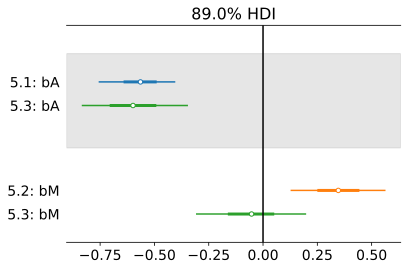

In [26]:
fig, ax = plt.subplots()
az.plot_forest(
    [trace_51, trace_52, trace_53],
    var_names=['bA', 'bM'],
    model_names=['5.1', '5.2', '5.3'],
    combined=True,
    hdi_prob=.89,
    ax=ax
)
ax.axvline(0, color='black')
plt.show()

### Code 5.12

In [27]:
N = 50
age = stats.norm().rvs(N)
mar = stats.norm(-age).rvs(N)
div = stats.norm(age).rvs(N)

### Code 5.13

In [28]:
with pm.Model() as model_54:
    a = pm.Normal('a', 0, .2)
    bAM = pm.Normal('bAM', 0, .5)
    mu = a + bAM*d['A']
    sigma = pm.Exponential('sigma', 1)
    M = pm.Normal('M', mu, sigma, observed=d['M'])
    trace_54 = pm.sample()

/tmp/ipykernel_3442/3796560886.py:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_54 = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bAM, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


### Code 5.14

In [29]:
mu = (trace_54['a'] + np.outer(d['A'], trace_54['bAM'])).T
mu_mean = mu.mean(axis=0)
mu_resid = d['M'] - mu_mean

### Code 5.15

In [30]:
mu = (trace_53['a'] + np.outer(d['A'], trace_53['bA']) + np.outer(d['M'], trace_53['bM'])).T
mu_mean = mu.mean(axis=0)
mu_pi = az.hdi(mu, hdi_prob=.89)

D_sim = stats.norm(mu.T, trace_53['sigma']).rvs().T
D_pi = az.hdi(D_sim, hdi_prob=.89)

/home/giuliano/.pyenv/versions/miniconda3-4.7.12/envs/statistical-rethinking/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


In [31]:
mu.shape, D_sim.shape

((4000, 50), (4000, 50))

In [32]:
mu_pi.shape, D_pi.shape

((50, 2), (50, 2))

### Code 5.16

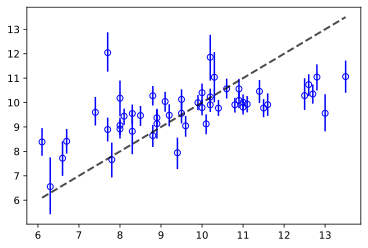

In [33]:
fig, ax = plt.subplots()
seq = np.linspace(d['Divorce'].min(), d['Divorce'].max(), 50)
ax.plot(seq, seq, color='black', linewidth=2, linestyle='--', alpha=.7)
ax.scatter(d['Divorce'], dstd_D(mu_mean), facecolors='none', edgecolors='blue')
ax.vlines(d['Divorce'], dstd_D(mu_pi[:, 0]), dstd_D(mu_pi[:, 1]), color='blue')
plt.show()

### Code 5.18

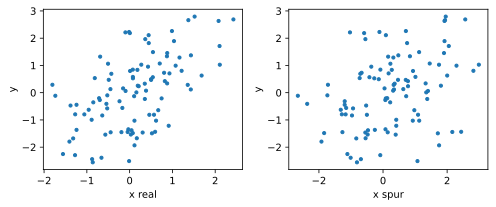

In [34]:
N = 100
x_real = stats.norm().rvs(N)
x_spur = stats.norm(x_real).rvs()
y = stats.norm(x_real).rvs()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))

ax1.scatter(x_real, y, s=10)
ax1.set_ylabel('y')
ax1.set_xlabel('x real')

ax2.scatter(x_spur, y, s=10)
ax2.set_ylabel('y')
ax2.set_xlabel('x spur')

fig.tight_layout()
plt.show()

### Code 5.19

In [35]:
with pm.Model() as model_53A:
    a = pm.Normal('a', 0, .2)
    bA = pm.Normal('bA', 0, .5)
    bM = pm.Normal('bM', 0, .5)
    mu = a + bA*d['A'] + bM*d['M']
    sigma = pm.Exponential('sigma', 1)
    D = pm.Normal('D', mu, sigma, observed=d['D'])    
    
    aM = pm.Normal('aM', 0, .2)
    bAM = pm.Normal('bAM', 0, .5)
    mu_M = a + bAM*d['A']
    sigma_M = pm.Exponential('sigma_M', 1)
    M = pm.Normal('M', mu_M, sigma_M, observed=d['M'])
    
    trace_53A = pm.sample(1000, tune=10000)

/tmp/ipykernel_3442/3615194285.py:15: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_53A = pm.sample(1000, tune=10000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_M, bAM, aM, sigma, bM, bA, a]


Sampling 4 chains for 10_000 tune and 1_000 draw iterations (40_000 + 4_000 draws total) took 30 seconds.


In [36]:
az.summary(trace_53A, kind='stats', hdi_prob=.89)

/home/giuliano/.pyenv/versions/miniconda3-4.7.12/envs/statistical-rethinking/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%
a,-0.001,0.071,-0.117,0.107
bA,-0.607,0.157,-0.856,-0.355
bM,-0.062,0.159,-0.309,0.200
aM,-0.000,0.199,-0.321,0.306
bAM,-0.696,0.101,-0.860,-0.540
sigma,0.824,0.086,0.677,0.950
sigma_M,0.710,0.074,0.592,0.821


### Code 5.20

In [37]:
A_seq = np.linspace(-2, 2, 50)

### Code 5.21

In [38]:
M_mu_seq = trace_53A['aM'] + np.outer(A_seq, trace_53A['bAM'])
M_sim_seq = stats.norm(M_mu_seq, trace_53A['sigma_M']).rvs()

In [39]:
D_mu_seq = trace_53A['a'] + np.outer(A_seq, trace_53A['bA']) + np.multiply(M_sim_seq, trace_53A['bM'])
D_sim_seq = stats.norm(D_mu_seq, trace_53A['sigma']).rvs()

### Code 5.22

/home/giuliano/.pyenv/versions/miniconda3-4.7.12/envs/statistical-rethinking/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/home/giuliano/.pyenv/versions/miniconda3-4.7.12/envs/statistical-rethinking/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


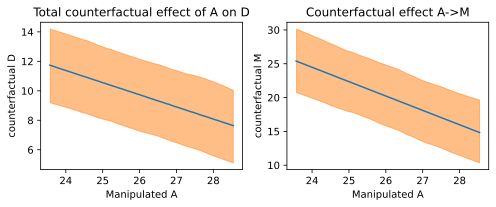

In [40]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))

ax1.set_title('Total counterfactual effect of A on D')
ax1.set_xlabel('Manipulated A')
ax1.set_ylabel('counterfactual D')
ax1.plot(dstd_A(A_seq), dstd_D(D_mu_seq.mean(axis=1)))
az.plot_hdi(dstd_A(A_seq), dstd_D(D_sim_seq.T), hdi_prob=.89, ax=ax1)

ax2.set_title('Counterfactual effect A->M')
ax2.set_xlabel('Manipulated A')
ax2.set_ylabel('counterfactual M')
ax2.plot(dstd_A(A_seq), dstd_M(M_mu_seq.mean(axis=1)))
az.plot_hdi(dstd_A(A_seq), dstd_M(M_sim_seq.T), hdi_prob=.89, ax=ax2)

fig.tight_layout()
plt.show()

### Code 5.23

In [41]:
A_seq = std_A(np.array([20, 30]))

In [42]:
M_mu_seq = trace_53A['aM'] + np.outer(A_seq, trace_53A['bAM'])
M_sim_seq = stats.norm(M_mu_seq, trace_53A['sigma_M']).rvs()

In [43]:
D_mu_seq = trace_53A['a'] + np.outer(A_seq, trace_53A['bA']) + np.multiply(M_sim_seq, trace_53A['bM'])
D_sim_seq = stats.norm(D_mu_seq, trace_53A['sigma']).rvs()

In [44]:
(D_sim_seq[1, :] - D_sim_seq[0, :]).mean()

-4.5379503520883535

In [45]:
(dstd_D(D_sim_seq[1, :]) - dstd_D(D_sim_seq[0, :])).mean()

-8.262763087156927

### Code 5.24

In [46]:
M_seq = np.linspace(-2, 2, 50)
D_mu_seq = trace_53A['a'] + 0*trace_53['bA'] + np.outer(M_seq, trace_53A['bM']) 
D_sim_seq = stats.norm(D_mu_seq, trace_53A['sigma']).rvs().T

/home/giuliano/.pyenv/versions/miniconda3-4.7.12/envs/statistical-rethinking/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


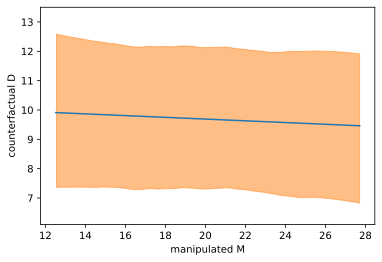

In [47]:
fig, ax = plt.subplots()

ax.plot(dstd_M(M_seq), dstd_D(D_mu_seq.mean(axis=1)))
az.plot_hdi(dstd_M(M_seq), dstd_D(D_sim_seq), hdi_prob=.89, ax=ax)
ax.set_ylim(d['Divorce'].min(), d['Divorce'].max())
ax.set_xlabel('manipulated M')
ax.set_ylabel('counterfactual D')

plt.show()

### Code 5.28

In [48]:
d = pd.read_csv('../../data/milk.csv', sep=';')

In [49]:
d.describe()

,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
count,29.000,29.000,29.000,29.000,29.000,17.000
mean,0.642,33.990,16.403,49.606,14.727,67.576
std,0.161,14.287,4.847,14.055,24.770,5.969
min,0.460,3.930,7.370,27.090,0.120,55.160
25%,0.490,21.220,13.000,37.800,1.620,64.540
50%,0.600,36.840,15.800,48.640,3.470,68.850
75%,0.730,46.080,20.770,60.120,10.720,71.260
max,0.970,55.510,25.300,71.910,97.720,76.300


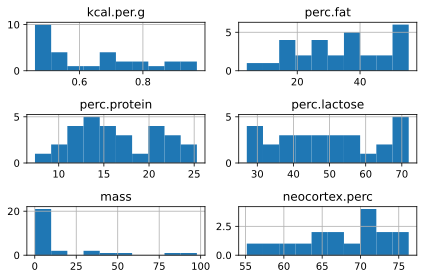

In [50]:
d.hist(bins=10)
plt.tight_layout()
plt.show()

### Code 5.29

In [51]:
std_K, dstd_K = create_standardizer_destandardizer(d['kcal.per.g'])
std_N, dstd_N = create_standardizer_destandardizer(d['neocortex.perc'])
std_M, dstd_M = create_standardizer_destandardizer(np.log(d['mass']))

In [52]:
d['K'] = std_K(d['kcal.per.g'])
d['N'] = std_N(d['neocortex.perc'])
d['M'] = std_M(np.log(d['mass']))

### Code 5.30

In [53]:
try:
    with pm.Model() as model_55_draft:
        a = pm.Normal('a', 0, 1)
        bN = pm.Normal('bN', 0, 1)
        N = pm.Data('N', d['N'])
        mu = a + bN * N
        sigma = pm.Exponential('sigma', 1)
        K = pm.Normal('K', mu, sigma, observed=d['K'])
        trace_55_draft = pm.sample()
except Exception as e:
    print(e)

Initial evaluation of model at starting point failed!
Starting values:
{'a': array(0.), 'bN': array(0.), 'sigma_log__': array(-0.36651292)}

Initial evaluation results:
a             -0.920
bN            -0.920
sigma_log__   -1.060
K                NaN
Name: Log-probability of test_point, dtype: float64


### Code 5.31

In [54]:
d['neocortex.perc']

0    55.160
1       NaN
2       NaN
3       NaN
4       NaN
5    64.540
6    64.540
7    67.640
8       NaN
9    68.850
10   58.850
11   61.690
12   60.320
13      NaN
14      NaN
15   69.970
16      NaN
17   70.410
18      NaN
19   73.400
20      NaN
21   67.530
22      NaN
23   71.260
24   72.600
25      NaN
26   70.240
27   76.300
28   75.490
Name: neocortex.perc, dtype: float64

### Code 5.32

In [55]:
dcc = d.dropna(subset=['K', 'N', 'M'])

### Code 5.33

In [56]:
with pm.Model() as model_55_draft:
    a = pm.Normal('a', 0, 1)
    bN = pm.Normal('bN', 0, 1)
    N = pm.Data('N', dcc['N'])
    mu = pm.Deterministic('mu', a + bN * N)
    sigma = pm.Exponential('sigma', 1)
    K = pm.Normal('K', mu, sigma, observed=dcc['K'])
    trace_55_draft = pm.sample()
    

/tmp/ipykernel_3442/2779786561.py:8: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_55_draft = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bN, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


### Code 5.34

In [57]:
with model_55_draft:
    x_seq = np.linspace(-2, 2, 30)
    pm.set_data({'N': x_seq})
    mu = pm.sample_prior_predictive(50, var_names=['mu'])['mu']

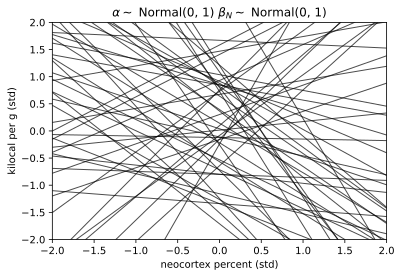

In [58]:
fig, ax = plt.subplots()

ax.set_title(r'$\alpha \sim$ Normal(0, 1) $\beta_N \sim $ Normal(0, 1)')
ax.set_xlabel('neocortex percent (std)')
ax.set_ylabel('kilocal per g (std)')

for i in range(mu.shape[0]):
    ax.plot(x_seq, mu[i, :], color='black', linewidth=1, alpha=.7)
    
ax.set_ylim(-2, 2)
ax.set_xlim(-2, 2)
plt.show()

### Code 5.35

In [59]:
with pm.Model() as model_55:
    a = pm.Normal('a', 0, .2)
    bN = pm.Normal('bN', 0, .5)
    N = pm.Data('N', dcc['N'])
    mu = pm.Deterministic('mu', a + bN * N)
    sigma = pm.Exponential('sigma', 1)
    K = pm.Normal('K', mu, sigma, observed=dcc['K'])
    trace_55 = pm.sample(5000, tune=10000)
    

/tmp/ipykernel_3442/85595119.py:8: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_55 = pm.sample(5000, tune=10000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bN, a]


Sampling 4 chains for 10_000 tune and 5_000 draw iterations (40_000 + 20_000 draws total) took 22 seconds.


In [60]:
with deepcopy(model_55):
    x_seq = np.linspace(-2, 2, 30)
    pm.set_data({'N': x_seq})
    mu = pm.sample_prior_predictive(50, var_names=['mu'])['mu']

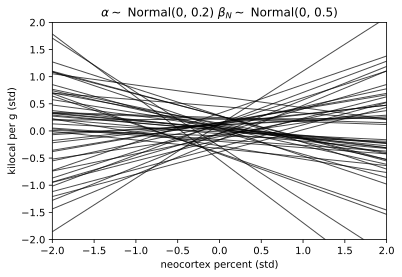

In [61]:
fig, ax = plt.subplots()

ax.set_title(r'$\alpha \sim$ Normal(0, 0.2) $\beta_N \sim $ Normal(0, 0.5)')
ax.set_xlabel('neocortex percent (std)')
ax.set_ylabel('kilocal per g (std)')

for i in range(mu.shape[0]):
    ax.plot(x_seq, mu[i, :], color='black', linewidth=1, alpha=.7)

ax.set_ylim(-2, 2)
ax.set_xlim(-2, 2)

plt.show()

### Code 5.36

In [62]:
az.summary(trace_55, kind='stats', hdi_prob=.89, var_names=['a', 'bN', 'sigma'])

/home/giuliano/.pyenv/versions/miniconda3-4.7.12/envs/statistical-rethinking/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%
a,0.037,0.163,-0.221,0.296
bN,0.125,0.245,-0.254,0.519
sigma,1.111,0.205,0.791,1.404


### Code 5.37

In [63]:
xseq = np.linspace(d['N'].min() - .15, d['N'].max() + .15, 30)
with deepcopy(model_55):
    pm.set_data({'N': xseq})
    mu = pm.sample_posterior_predictive(trace_55, var_names=['mu'])['mu']

/home/giuliano/.pyenv/versions/miniconda3-4.7.12/envs/statistical-rethinking/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


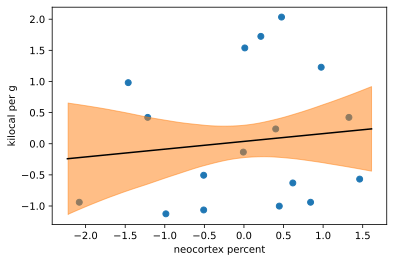

In [64]:
fig, ax = plt.subplots()
ax.scatter(dcc['N'], dcc['K'])
ax.plot(xseq, mu.mean(axis=0), color='black')
az.plot_hdi(xseq, mu, hdi_prob=.89, ax=ax)
ax.set_xlabel('neocortex percent')
ax.set_ylabel('kilocal per g')

plt.show()

### Code 5.38

In [65]:
with pm.Model() as model_56:
    a = pm.Normal('a', 0, .2)
    bM = pm.Normal('bM', 0, .5)
    M = pm.Data('M', dcc['M'])
    mu = pm.Deterministic('mu', a + bM*M)
    sigma = pm.Exponential('sigma', 1)
    K = pm.Normal('K', mu, sigma, observed=dcc['K'])
    trace_56 = pm.sample(5000, tune=10_000)

/tmp/ipykernel_3442/2260046218.py:8: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_56 = pm.sample(5000, tune=10_000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bM, a]


Sampling 4 chains for 10_000 tune and 5_000 draw iterations (40_000 + 20_000 draws total) took 13 seconds.


In [66]:
az.summary(trace_56, kind='stats', hdi_prob=.89, var_names=['a', 'bM', 'sigma'])

/home/giuliano/.pyenv/versions/miniconda3-4.7.12/envs/statistical-rethinking/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%
a,0.041,0.157,-0.212,0.288
bM,-0.268,0.215,-0.627,0.058
sigma,1.058,0.196,0.757,1.339


In [67]:
xseq = np.linspace(d['M'].min() - .15, d['M'].max() + .15, 30)
with deepcopy(model_56):
    pm.set_data({'M': xseq})
    mu = pm.sample_posterior_predictive(trace_56, var_names=['mu'])['mu']

/home/giuliano/.pyenv/versions/miniconda3-4.7.12/envs/statistical-rethinking/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


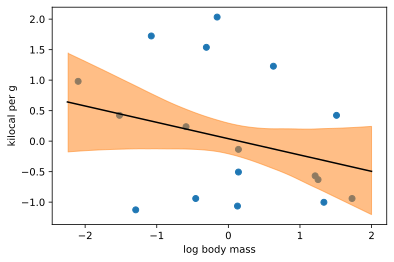

In [68]:
fig, ax = plt.subplots()
ax.scatter(dcc['M'], dcc['K'])
ax.plot(xseq, mu.mean(axis=0), color='black')
az.plot_hdi(xseq, mu, hdi_prob=.89, ax=ax)
ax.set_xlabel('log body mass')
ax.set_ylabel('kilocal per g')

plt.show()

### Code 5.39

In [69]:
with pm.Model() as model_57:
    a = pm.Normal('a', 0, .2)
    bM = pm.Normal('bM', 0, .5)
    bN = pm.Normal('bN', 0, .5)
    
    M = pm.Data('M', dcc['M'])
    N = pm.Data('N', dcc['N'])
    
    mu = pm.Deterministic('mu', a + bM*M + bN*N)
    sigma = pm.Exponential('sigma', 1)
    K = pm.Normal('K', mu, sigma, observed=dcc['K'])
    
    trace_57 = pm.sample(5000, tune=10_000)

/tmp/ipykernel_3442/1743231482.py:13: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_57 = pm.sample(5000, tune=10_000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bN, bM, a]


Sampling 4 chains for 10_000 tune and 5_000 draw iterations (40_000 + 20_000 draws total) took 23 seconds.


In [70]:
az.summary(trace_57, kind='stats', hdi_prob=.89, var_names=['a', 'bN', 'bM', 'sigma'])

/home/giuliano/.pyenv/versions/miniconda3-4.7.12/envs/statistical-rethinking/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%
a,0.060,0.145,-0.159,0.302
bN,0.605,0.278,0.168,1.047
bM,-0.640,0.249,-1.038,-0.253
sigma,0.865,0.183,0.589,1.125


/home/giuliano/.pyenv/versions/miniconda3-4.7.12/envs/statistical-rethinking/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


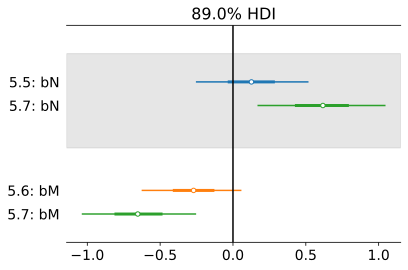

In [71]:
fig, ax = plt.subplots()
az.plot_forest(
    [trace_55, trace_56, trace_57],
    var_names=['bN', 'bM'],
    model_names=['5.5', '5.6', '5.7'],
    combined=True,
    hdi_prob=.89,
    ax=ax
)
ax.axvline(0, color='black')
plt.show()

### Code 5.41

In [72]:
xseq_N = np.linspace(d['N'].min() - .15, d['N'].max() + .15, 30)
xseq_M = np.linspace(d['M'].min() - .15, d['M'].max() + .15, 30)

with deepcopy(model_57):
    pm.set_data({'N': xseq_N, 'M': np.zeros(len(xseq_N))})
    mu1 = pm.sample_posterior_predictive(trace_57, var_names=['mu'])['mu']
    pm.set_data({'M': xseq_M, 'N': np.zeros(len(xseq_N))})
    mu2 = pm.sample_posterior_predictive(trace_57, var_names=['mu'])['mu']
    

/home/giuliano/.pyenv/versions/miniconda3-4.7.12/envs/statistical-rethinking/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/home/giuliano/.pyenv/versions/miniconda3-4.7.12/envs/statistical-rethinking/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


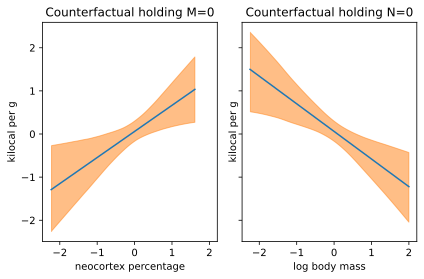

In [73]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True)

ax1.set_title('Counterfactual holding M=0')
ax1.set_xlabel('neocortex percentage')
ax1.set_ylabel('kilocal per g')
ax1.plot(xseq_N, mu1.mean(axis=0))
az.plot_hdi(xseq_N, mu1, hdi_prob=.89, ax=ax1)

ax2.set_title('Counterfactual holding N=0')
ax2.set_xlabel('log body mass')
ax2.set_ylabel('kilocal per g')
ax2.plot(xseq_M, mu2.mean(axis=0))
az.plot_hdi(xseq_M, mu2, hdi_prob=.89, ax=ax2)


fig.tight_layout()
plt.show()

### Code 5.42

In [74]:
# M -> K <- N
# M -> N

n = 100
M = np.random.normal(size=n)
N = np.random.normal(loc=M)
K = np.random.normal(loc=N-M)
d_sim = pd.DataFrame({'K': K, 'N': N,'M': M})

### Code 5.43

In [75]:
# M -> K <- N
# N -> M

n = 100
N = stats.norm().rvs(n)
M = stats.norm(N).rvs(100)
K = stats.norm(N - M).rvs(100)
d_sim2 = pd.DataFrame({"K": K, "M": M, "N": N})

# M -> K <- N
# M <- U -> N

n = 100
U = stats.norm().rvs(n)
N = stats.norm(U).rvs(n)
M = stats.norm(U).rvs(100)
K = stats.norm(N - M).rvs(100)
d_sim3 = pd.DataFrame({"K": K, "M": M, "N": N})

### Code 5.45

In [76]:
d = pd.read_csv('../../data/Howell1.csv', sep=';')

In [77]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544 entries, 0 to 543
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   height  544 non-null    float64
 1   weight  544 non-null    float64
 2   age     544 non-null    float64
 3   male    544 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 17.1 KB


### Code 5.46

In [78]:
mu_female = np.random.normal(loc=178, scale=20, size=10_000)
mu_male = np.random.normal(loc=178, scale=20, size=10_000) + np.random.normal(loc=0, scale=10, size=10_000)
dd = pd.DataFrame({'mu_female': mu_female, 'mu_male': mu_male})

In [79]:
dd.describe()

,mu_female,mu_male
count,"10,000.000","10,000.000"
mean,177.823,178.245
std,19.868,22.067
min,103.911,86.539
25%,164.593,163.450
50%,177.760,178.335
75%,191.414,193.083
max,261.789,257.701


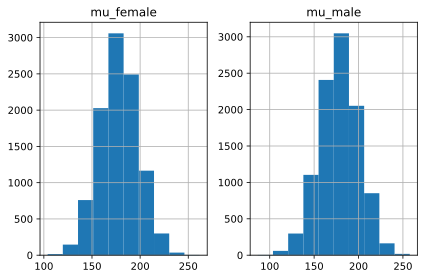

In [80]:
dd.hist()
plt.tight_layout()
plt.show()

### Code 5.47 

In [81]:
d['sex'] = np.where(d['male'] == 1, 1, 0)
d['sex']

0      1
1      0
2      0
3      1
4      0
      ..
539    1
540    1
541    0
542    1
543    1
Name: sex, Length: 544, dtype: int64

### Code 5.48

In [82]:
with pm.Model() as model_58:
    a = pm.Normal('a', 178, 20, shape=2)
    mu = a[d['sex'].values]
    sigma = pm.Uniform('sigma', 0, 50)
    height = pm.Normal('height', mu, sigma, observed=d['height'])
    trace_58 = pm.sample()

/tmp/ipykernel_3442/3785587516.py:6: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_58 = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [83]:
az.summary(trace_58, hdi_prob=.89, kind='stats')

/home/giuliano/.pyenv/versions/miniconda3-4.7.12/envs/statistical-rethinking/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%
a[0],134.946,1.624,132.429,137.518
a[1],142.585,1.764,139.791,145.360
sigma,27.419,0.858,26.129,28.812


### Code 5.49

In [84]:
diff_fm = pd.Series(trace_58['a'][:, 0] - trace_58['a'][:, 1])
diff_fm.describe(percentiles=[.055, .945])

count   4,000.000
mean       -7.639
std         2.425
min       -16.654
5.5%      -11.573
50%        -7.684
94.5%      -3.686
max         0.214
dtype: float64

### Code 5.50

In [85]:
d = pd.read_csv('../../data/milk.csv', sep=';')

In [86]:
sorted(d['clade'].unique().tolist())

['Ape', 'New World Monkey', 'Old World Monkey', 'Strepsirrhine']

### Code 5.51

In [87]:
d['clade'] = d['clade'].astype('category')

### Code 5.52 

In [88]:
d['K'] = (d['kcal.per.g'] - d['kcal.per.g'].mean()) / d['kcal.per.g'].std()

In [89]:
with pm.Model() as model_59:
    a = pm.Normal('a', 0, .5, shape=d['clade'].nunique())
    mu = a[d['clade'].cat.codes]
    sigma = pm.Normal('sigma', 1)
    K = pm.Normal('K', mu, sigma, observed=d['K'])
    trace_59 = pm.sample()

/tmp/ipykernel_3442/2160624904.py:6: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_59 = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


/home/giuliano/.pyenv/versions/miniconda3-4.7.12/envs/statistical-rethinking/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


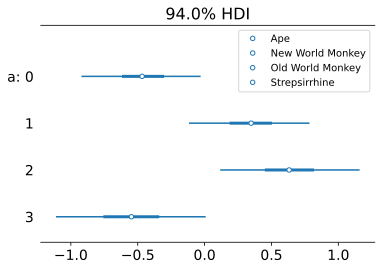

In [90]:
fig, ax = plt.subplots()
az.plot_forest(trace_59, var_names=['a'], ax=ax, combined=True)
ax.legend(d['clade'].cat.categories)

### Code 5.53

In [91]:
d["house"] = np.random.randint(0, 4, size=d.shape[0])

### Code 5.54

In [92]:
with pm.Model() as model_510:
    sigma = pm.Exponential("sigma", 1)
    mu_house = pm.Normal("mu_house", 0, 0.5, shape=d["house"].nunique())
    mu_clade = pm.Normal("mu_clade", 0, 0.5, shape=d["clade"].nunique())
    mu = mu_clade[d["clade"].cat.codes] + mu_house[d["house"].values]

    K = pm.Normal("K", mu, sigma, observed=d["K"])

    trace_510 = pm.sample()

az.summary(trace_510, var_names=["mu_clade", "mu_house"])

/tmp/ipykernel_3442/2181849341.py:9: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_510 = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_clade, mu_house, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
/home/giuliano/.pyenv/versions/miniconda3-4.7.12/envs/statistical-rethinking/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_clade[0],-0.467,0.286,-1.024,0.048,0.005,0.004,"2,891.000","2,524.000",1.000
mu_clade[1],0.381,0.278,-0.152,0.891,0.005,0.004,"2,915.000","3,071.000",1.000
mu_clade[2],0.633,0.314,0.083,1.258,0.005,0.004,"3,366.000","3,302.000",1.000
mu_clade[3],-0.591,0.330,-1.227,-0.018,0.006,0.004,"3,284.000","2,787.000",1.000
mu_house[0],0.184,0.284,-0.370,0.680,0.005,0.004,"2,860.000","2,752.000",1.000
mu_house[1],-0.146,0.292,-0.689,0.405,0.005,0.004,"3,040.000","2,810.000",1.000
mu_house[2],0.044,0.330,-0.586,0.643,0.006,0.005,"3,339.000","2,832.000",1.000
mu_house[3],-0.108,0.303,-0.664,0.475,0.005,0.004,"3,156.000","2,965.000",1.000


## Figures

### Figure 5.4

In [93]:
d = pd.read_csv('../../data/WaffleDivorce.csv', sep=';')

std_D, dstd_D = create_standardizer_destandardizer(d['Divorce'])
std_M, dstd_M = create_standardizer_destandardizer(d['Marriage'])
std_A, dstd_A = create_standardizer_destandardizer(d['MedianAgeMarriage'])

In [94]:
with pm.Model() as model_A_to_M:
    a = pm.Normal('a', 0, .2)
    bA = pm.Normal('bA', 0, .5)
    mu = a + bA * std_A(d['MedianAgeMarriage'])
    sigma = pm.Exponential('sigma', 1)
    marriage = pm.Normal('marriage', mu, sigma, observed=std_M(d['Marriage']))
    trace_A_to_M = pm.sample(return_inferencedata=False)

AM_mean = (trace_A_to_M['a'] + np.outer(std_A(d['MedianAgeMarriage']), trace_A_to_M['bA'])).mean(axis=1)
AM_resid = std_M(d['Marriage']) - AM_mean

with pm.Model() as model_AMR_to_D:
    a = pm.Normal('a', 0, .2)
    bAMR = pm.Normal('bAMR', 0, .5)
    mu = a + bAMR * AM_resid
    sigma = pm.Exponential('sigma', 1)
    divorce = pm.Normal('divorce', mu, sigma, observed=std_D(d['Divorce']))
    trace_AMR_to_D = pm.sample(return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bA, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bAMR, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [95]:
with pm.Model() as model_M_to_A:
    a = pm.Normal('a', 0, .2)
    bM = pm.Normal('bM', 0, .5)
    mu = a + bM * std_M(d['Marriage'])
    sigma = pm.Exponential('sigma', 1)
    age = pm.Normal('age', mu, sigma, observed=std_A(d['MedianAgeMarriage']))
    trace_M_to_A = pm.sample(return_inferencedata=False)

MA_mean = (trace_M_to_A['a'] + np.outer(std_M(d['Marriage']), trace_M_to_A['bM'])).mean(axis=1)
MA_resid = std_A(d['MedianAgeMarriage']) - MA_mean

with pm.Model() as model_MAR_to_D:
    a = pm.Normal('a', 0, .2)
    bMAR = pm.Normal('bMAR', 0, .5)
    mu = a + bMAR * MA_resid
    sigma = pm.Exponential('sigma', 1)
    divorce = pm.Normal('divorce', mu, sigma, observed=std_D(d['Divorce']))
    trace_MAR_to_D = pm.sample(return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bM, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bMAR, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
The acceptance probability does not match the target. It is 0.8833461379851578, but should be close to 0.8. Try to increase the number of tuning steps.


/home/giuliano/.pyenv/versions/miniconda3-4.7.12/envs/statistical-rethinking/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/home/giuliano/.pyenv/versions/miniconda3-4.7.12/envs/statistical-rethinking/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


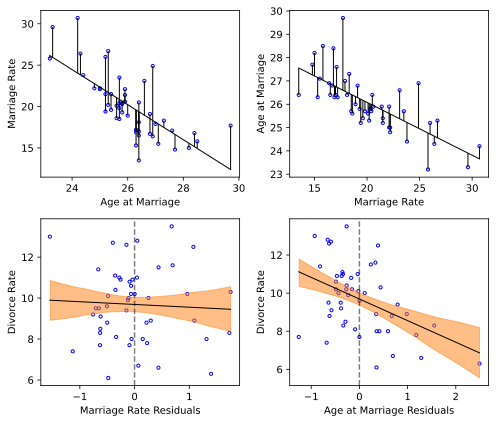

In [96]:
fig, axes = plt.subplots(2, 2, figsize=(7, 6))

# Age to Marriage
axes[0, 0].set_xlabel('Age at Marriage')
axes[0, 0].set_ylabel('Marriage Rate')
axes[0, 0].scatter(d['MedianAgeMarriage'], d['Marriage'], facecolors='none', edgecolors='blue', s=10)

xline = std_A(np.linspace(d['MedianAgeMarriage'].min(), d['MedianAgeMarriage'].max()))
yline = (trace_A_to_M['a'] + np.outer(xline, trace_A_to_M['bA'])).mean(axis=1)
axes[0, 0].plot(dstd_A(xline), dstd_M(yline), color='black', linewidth=1)
axes[0, 0].vlines(d['MedianAgeMarriage'], d['Marriage'], dstd_M(AM_mean), color='black', linewidth=1)


# (Age to Marriage residuals) to Divorce
axes[1, 0].set_xlabel('Marriage Rate Residuals')
axes[1, 0].set_ylabel('Divorce Rate')
axes[1, 0].scatter(AM_resid, d['Divorce'], facecolors='none', edgecolors='blue', s=10)
axes[1, 0].axvline(0, color='black', linestyle='--', alpha=.5)

xline = np.linspace(AM_resid.min(), AM_resid.max(), 50)
yline = (trace_AMR_to_D['a'] + np.outer(xline, trace_AMR_to_D['bAMR'])).T
axes[1, 0].plot(xline, dstd_D(yline.mean(axis=0)), color='black', linewidth=1)
az.plot_hdi(xline, dstd_D(yline), hdi_prob=.89, ax=axes[1, 0])


# Marriage to Age
axes[0, 1].set_ylabel('Age at Marriage')
axes[0, 1].set_xlabel('Marriage Rate')
axes[0, 1].scatter(d['Marriage'], d['MedianAgeMarriage'], facecolors='none', edgecolors='blue', s=10)

xline = std_M(np.linspace(d['Marriage'].min(), d['Marriage'].max()))
yline = (trace_M_to_A['a'] + np.outer(xline, trace_M_to_A['bM'])).mean(axis=1)
axes[0, 1].plot(dstd_M(xline), dstd_A(yline), color='black', linewidth=1)
axes[0, 1].vlines(d['Marriage'], d['MedianAgeMarriage'], dstd_A(MA_mean), color='black', linewidth=1)


# (Marriage to Age residuals) to Divorce
axes[1, 1].set_xlabel('Age at Marriage Residuals')
axes[1, 1].set_ylabel('Divorce Rate')
axes[1, 1].scatter(MA_resid, d['Divorce'], facecolors='none', edgecolors='blue', s=10)
axes[1, 1].axvline(0, color='black', linestyle='--', alpha=.5)

xline = np.linspace(MA_resid.min(), MA_resid.max(), 50)
yline = (trace_MAR_to_D['a'] + np.outer(xline, trace_MAR_to_D['bMAR'])).T
axes[1, 1].plot(xline, dstd_D(yline.mean(axis=0)), color='black', linewidth=1)
az.plot_hdi(xline, dstd_D(yline), hdi_prob=.89, ax=axes[1, 1])


fig.tight_layout()
plt.show()